In [122]:
#####Bi-level model for Rare temporal pattern detection####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [123]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [124]:
####データの発生####
##データの設定
k = 2   #混合数
m0 = 3   #正常状態での潜在変数数
m1 = 2   #異常状態での潜在変数数
hh = 5000   #ユーザー数
pt = np.random.poisson(np.random.gamma(50, 1/0.2, hh), hh)   #系列数
hhpt = np.sum(pt)   #総レコード数

In [125]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [126]:
##潜在パラメータとユーザーの異常状態を生成
#潜在変数のパラメータ
alpha = np.repeat(1.0, m0*m0).reshape(m0, m0) + np.diag(np.repeat(1.5, m0))
pi = np.array([0.03])   #ユーザーの混合率
gamma = np.array([0.075, 0.6])   #正常状態と異常状態の切換率
delta = np.array([0.5])   #異常状態の混合率
omega0 = np.append(np.random.dirichlet(np.repeat(2.5, m0), 1).reshape(-1), 0) 
omega1 = np.append((1-gamma[0])*omega0[:m0], gamma[0])
theta0 = np.zeros((m0+1, m0+1))
for j in range(m0):
    theta0[j, :m0] = np.random.dirichlet(alpha[j, ], 1)
theta1 = np.hstack(((1-gamma[0])*theta0[:m0, :m0], np.repeat(gamma[0], m0)[:, np.newaxis]))
theta1 = np.vstack((theta1, np.append(((1-gamma[1])*np.random.dirichlet(np.repeat(1.0, m0))), gamma[1])))
pit = pi.copy(); gammat = gamma.copy(); deltat = delta.copy()
omegat0 = omega0.copy(); omegat1 = omega1.copy(); thetat0 = theta0.copy(); thetat1 = theta1.copy()
    
#ユーザーの潜在変数を生成
Z = np.random.binomial(1, pi, hh)
index_z = np.array(np.where(Z==1)[0], dtype="int")
n = index_z.shape[0]

#異常状態の潜在変数を生成
A = np.repeat(0, hh)
A[index_z] = np.random.binomial(1, delta, n) + 1

In [127]:
##ユーザーごとに系列の異常状態を生成
#データの格納用リスト
S_list = [i for i in range(hh)]
s_list = [i for i in range(hh)]

for i in range(hh):
    #系列の格納用配列
    S = np.array(np.zeros((pt[i], m0+1)), dtype="int")
    s = np.repeat(0, pt[i])

    #正常ユーザーの潜在変数を生成
    if Z[i]==0:
        for j in range(pt[i]):
            if j==0:
                S[j, ] = np.random.multinomial(1, omega0, 1)
            else:
                index = np.argmax(S[j-1, ])
                S[j, ] = np.random.multinomial(1, theta0[index, ])

    #異常ユーザーの潜在変数を生成
    else:
        for j in range(pt[i]):
            if j==0:
                S[j, ] = np.random.multinomial(1, omega1, 1)
                if S[j, m0]==1:
                    s[j, ] = 1
            else:
                index = np.argmax(S[j-1, ]) 
                S[j, ] = np.random.multinomial(1, theta1[index, ], 1)
                if S[j, m0]==1:
                    s[j] = 1
                    
    #生成したデータの格納
    S_list[i] = S
    s_list[i] = s

In [128]:
#リストを変換
S = np.array(list(itertools.chain(*[S_list[i] for i in range(hh)])))
s = np.array(list(itertools.chain(*[s_list[i] for i in range(hh)])))
s_vec = np.dot(S, np.arange(m0 + 1))
print(np.sum(S, axis=0))

[ 26657 386330 835253   5281]


In [129]:
##潜在変数からデータを生成
#妥当な数値が生成されるまで繰り返す
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #ユーザーの入力変数を生成
    k1 = 4; k2 = 4; k3 = 5
    u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
    u2 = np.zeros((hh, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        u2[:, j] = np.random.binomial(1, prob, hh)
    u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
    u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
    x1 = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)

    #素性ベクトルを生成
    k1 = 5; k2 = 6; k3 = 4
    u1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
    u2 = np.zeros((hhpt, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        u2[:, j] = np.random.binomial(1, prob, hhpt)
    u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
    u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
    x2 = np.concatenate((u1, u2, u3), axis=1)
    x = np.hstack((x1[user_id, ], x2))
    col_x = x.shape[1]
    
    #モデルパラメータを生成
    alpha0 = np.random.uniform(2.0, 2.5, m0)
    alpha1 = np.random.uniform(2.0, 2.5, m0)
    beta0 = np.append(np.random.uniform(0.5, 2.2, m0), np.random.normal(0, 0.4, (col_x-1)*m0)).reshape(col_x, m0)
    beta1 = np.append(np.array([np.random.uniform(-1.0, -0.2, 1), np.random.uniform(2.4, 3.0, 1)]).reshape(-1), 
                      np.random.normal(0, 0.4, (col_x-1)*m1)).reshape(col_x, m1)
    alphat0 = alpha0.copy(); alphat1 = alpha1.copy()
    betat0 = beta0.copy(); betat1 = beta1.copy()

    
    #正常値のデータを生成
    s_allocation = np.repeat(0, hhpt)
    s0_vec = np.dot(S[:, :m0], np.arange(m0))
    y = np.repeat(0.0, hhpt)
    index_s0 = np.array(np.where(s!=1)[0], dtype="int")
    N0 = index_s0.shape[0]
    mu = np.exp(np.sum(np.dot(x[index_s0, ], beta0) * S[index_s0, :m0], axis=1))
    y[index_s0] = np.random.gamma(mu, 1/alpha0[s0_vec[index_s0]], N0)

    #異常値のデータを生成
    index_s1 = np.array(np.where(s==1)[0], dtype="int")
    N1 = index_s1.shape[0]
    mu = np.exp(np.sum(np.dot(x[index_s1, ], beta1) * np.eye(m1)[A[user_id[index_s1]]-1], axis=1))
    y[index_s1] = np.random.gamma(mu, 1/alpha1[A[user_id[index_s1]]-1], N1)

    #応答変数の集計
    s_allocation = s_vec.copy()
    s_allocation[index_s1] = A[user_id[index_s1]] + m0 - 1
    y_mean = np.repeat(0.0, m0+m1)
    y_sd = np.repeat(0.0, m0+m1)
    for j in np.unique(s_allocation):
        index = np.where(s_allocation==j)[0]
        y_mean[j] = np.mean(y[index])
        y_sd[j] = np.std(y[index])

    #break条件
    if (np.min(y_mean[:m0]) > 1.5) & (np.max(y_mean[:m0]) < 10.0) & (y_mean[m0] < 1.0) & (y_mean[m0+1] > 10.0) & (y_mean[m0+1] < 17.5):
        break

1


[ 1.853  2.086  1.969  0.546 14.243]
[ 2.36   2.138  2.031  0.648 14.531]


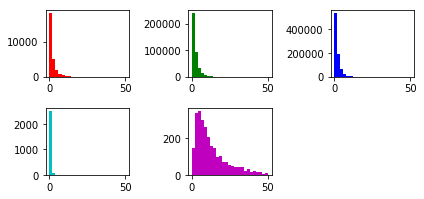

In [130]:
#生成したデータの確認
log_y = np.log(y)
print(np.round(y_mean, 3))
print(np.round(y_sd, 3))

#潜在変数ごとのヒストグラム
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure()
for j in range(m0+m1):
    ax = fig.add_subplot(3, 3, j+1)
    ax.hist(y[s_allocation==j],  bins=25, range=(0, 50), color=colorlist[j])
fig.tight_layout()
plt.show()

In [131]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##ガンマ回帰の対数尤度
def loglike(alpha, beta, d, d_log, x):
    #対数尤度を設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log
    
    #対数尤度の和
    LL = np.sum(Lho)
    return LL, Lho 
    
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [132]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [133]:
##アルゴリズムの設定
R = 3000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.0025
e2 = 0.01
L = 3

In [134]:
##インデックスの設定
#先頭と後尾のインデックスを作成
max_pt = np.max(pt_id) + 1
index_t1 = np.array(np.where(pt_id==0)[0], dtype="int")
index_t12 = np.repeat(0, hh)
for i in range(hh):
    index_t12[i] = np.max(user_list[i])
    
#中間のインデックスを作成
index_list_t21 = [j for j in range(max_pt-1)]
index_list_t22 = [j for j in range(max_pt-1)]
for j in range(1, max_pt):
    index_list_t21[j-1] = np.array(np.where(pt_id==j)[0], dtype="int") - 1
    index_list_t22[j-1] = np.array(np.where(pt_id==j)[0], dtype="int")
index_t21 = np.sort(np.array(list(itertools.chain(*[index_list_t21[j] for j in range(max_pt-1)]))))
index_t22 = np.sort(np.array(list(itertools.chain(*[index_list_t22[j] for j in range(max_pt-1)]))))

In [168]:
##パラメータの真値
#潜在変数の割当率のパラメータの真値
pi = pit.copy()  
gamma = gammat.copy()
delta = deltat.copy()
omega0 = omegat0.copy()
omega1 = omegat1.copy()
theta0 = thetat0.copy()
theta1 = thetat1.copy()

#潜在変数の真値
Zi = Z
Ai = A
si = s
Si = S.copy()
Si0 = Si[:, :m0].copy()
Si0[np.where(Si[:, m0]==1)[0], ] = np.random.multinomial(1, omega0[:m0], np.sum(Si[:, m0]))
s0_vec = np.dot(Si0, np.arange(m0))
s1_vec = np.dot(Si, np.arange(m0+1))

#モデルパラメータの真値
alpha0 = alphat0
alpha1 = alphat1
alpha = np.append(alpha0, alpha1)
beta0 = betat0
beta1 = betat1
beta = np.hstack((beta0, beta1))

In [169]:
##ユーザーの状態ごとの潜在変数を生成
#潜在変数ごとのガンマ回帰の尤度
Lho = np.zeros((hhpt, m0+m1))
for j in range(m0+m1):
    Lho[:, j] = np.exp(loglike(beta[:, j], alpha[j], y, log_y, x)[1])
Lho_new = np.hstack((Lho[:, :m0], np.sum(Lho[:, m0:], axis=1)[:, np.newaxis]))

In [170]:
#HMMの混合率と推移確率
theta_dt01 = np.full((hhpt, m0), 1/m0); theta_dt02 = theta_dt01.copy()
theta_dt11 = np.full((hhpt, m0+1), 1/(m0+1)); theta_dt12 = theta_dt11.copy()
theta_dt01[index_t1, ] = np.full((hh, m0), omega0[:m0])
theta_dt01[index_t22, ] = theta0[:m0, :m0][s0_vec[index_t21], ]
theta_dt02[index_t21, ] = (theta0[:m0, :m0].T)[s0_vec[index_t22], ]
theta_dt11[index_t1, ] = np.full((hh, m0+1), omega1)
theta_dt11[index_t22, ] = theta1[s1_vec[index_t21], ]
theta_dt12[index_t21, ] = (theta1.T)[s1_vec[index_t22], ]

In [171]:
#潜在変数ごとの事後分布と期待値
Posterior0 = theta_dt01 * theta_dt02 * Lho_new[:, :m0]
Posterior1 = theta_dt11 * theta_dt12 * Lho_new
new_posterior0 = np.dot(Posterior0, np.repeat(1, m0))[:, np.newaxis]
new_posterior1 = np.dot(Posterior1, np.repeat(1, m0+1))[:, np.newaxis]

In [172]:
#ユーザーごとの潜在変数の事後分布
pi_vec = np.append(1-pi, pi)
new_posterior = np.zeros((hh, 2))
for i in range(hh):
    index = user_list[i]
    Posterior = np.sum(np.log(np.hstack((new_posterior0[index, ], new_posterior1[index, ]))), axis=0)
    new_posterior[i, ] = pi_vec * np.exp(Posterior - np.max(Posterior))   #ユーザーごとの潜在変数の事後分布

#ベルヌーイ分布からユーザーの状態をサンプリング
z_rate = new_posterior / np.sum(new_posterior, axis=1)[:, np.newaxis]   #潜在変数の割当確率
Zi = np.random.binomial(1, z_rate[:, 1], hh)
index_z = np.array(np.where(Zi==1)[0], dtype="int")
n = index_z.shape[0]

In [187]:
i = 5
index = index_z[i]
np.sum(np.log(Lho[user_list[index], m0:]), axis=0)
np.sum(np.log(Lho[user_list[index], ]), axis=0)

array([-788.9586195 , -598.51463853, -661.4655022 , -585.10845111,
       -966.17538742])

In [188]:
Posterior1

array([[1.64141696e-04, 9.54201201e-03, 3.18453999e-02, 4.72445391e-04],
       [1.43156982e-07, 3.06270451e-02, 9.96869395e-02, 9.41095247e-04],
       [7.11986613e-08, 1.47965234e-02, 8.21698388e-02, 1.12754738e-04],
       ...,
       [1.03835244e-05, 3.69158659e-02, 3.67787612e-02, 7.29293510e-05],
       [4.00729366e-07, 1.07942453e-02, 9.97322487e-02, 2.42909923e-04],
       [5.84778110e-05, 2.79017848e-02, 1.37458649e-01, 9.54413124e-03]])

In [167]:
np.sum(Z)
n

134

In [417]:
#ユーザーごとの潜在変数の事後分布を設定
new_posterior0 = np.sum(Posterior0, axis=1)
new_posterior1 = np.sum(Posterior1, axis=1)
new_posterior = np.zeros((hh, 2))
for i in range(hh):
    Posterior = np.append(np.sum(np.log(new_posterior0[user_list[i]])), np.sum(np.log(new_posterior1[user_list[i]])))
    new_posterior[i, ] = np.array([pi, 1-pi]) * np.exp(Posterior - np.max(Posterior))

In [419]:
z_rate = new_posterior / np.sum(new_posterior, axis=1)[:, np.newaxis]


In [429]:
i = 1000
print(z_rate[i, ])


[9.19639226e-11 1.00000000e+00]


In [422]:
index_z

array([  17,   23,   33,  130,  140,  153,  159,  177,  181,  214,  263,
        288,  328,  337,  374,  375,  403,  450,  496,  534,  582,  583,
        609,  658,  685,  746,  773,  810,  814,  859,  911,  942,  970,
        992, 1004, 1012, 1044, 1062, 1087, 1124, 1146, 1207, 1221, 1311,
       1366, 1399, 1409, 1431, 1439, 1487, 1512, 1526, 1557, 1627, 1672,
       1680, 1695, 1702, 1721, 1722, 1746, 1770, 1775, 1777, 1888, 1893,
       1923, 1932, 1943, 1957, 1966, 1976, 1997, 2014, 2037, 2080, 2138,
       2212, 2217, 2352, 2373, 2403, 2417, 2475, 2478, 2480, 2490, 2547,
       2600, 2661, 2683, 2750, 2758, 2762, 2802, 2844, 2860, 2880, 2939,
       3006, 3009, 3036, 3047, 3074, 3103, 3120, 3179, 3209, 3253, 3293,
       3354, 3394, 3406, 3431, 3450, 3523, 3545, 3568, 3586, 3624, 3694,
       3754, 3797, 3821, 3859, 3911, 3918, 3956, 3978, 3982, 4040, 4047,
       4075, 4109, 4112, 4116, 4203, 4214, 4305, 4341, 4385, 4398, 4403,
       4423, 4451, 4465, 4499, 4503, 4510, 4514, 45

In [98]:
Posterior

array([[0.13016774, 0.05378805, 0.37184295, 0.05567064]])

In [113]:
(2409*10)*0.05

1204.5

In [75]:
np.anp.arange(m0)

array([0, 1, 2, 3])

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.6 ])